In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/hive-0.9.0.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [2]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])

In [3]:
print(X_train.shape)
print(X_test.shape)

(1132, 66)
(284, 66)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [4]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 906 samples
  Minority class (True): 226 samples
  Imbalance ratio: 1:4.01

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 906 -> 566 samples
Reduction: 62.5%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
No valid clusters found. Using single cluster.
Applying SMOTE balancing to minority class...
Cluster distribution: {0: 226}
Cluster weights: {0: 1.0}
Cluster 0: 226 -> 566 samples
Minority class: 226 -> 566 samples
Change: 250.4%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
Final distribution:
  Class False: 566 samples
  Class True: 566 samples
Total samples: 1132
Bal

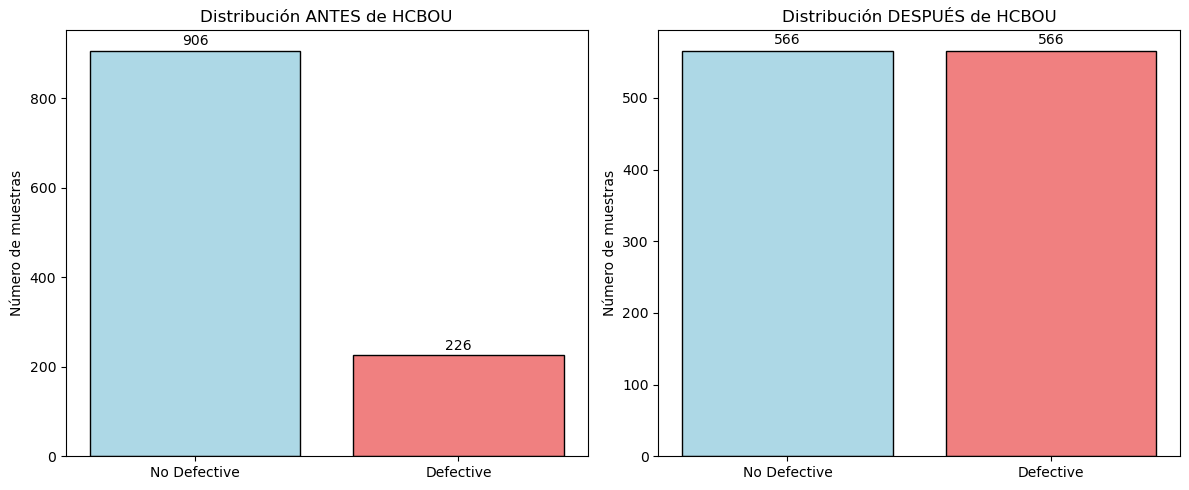


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (1132, 65)
Shape final y_train_balanced: (1132,)


In [5]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)

In [7]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,...,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000
mean,2.261484,10.787986,577.043286,7.419611,0.618375,1.161661,3.396643,97.734982,2.257067,13.697880,...,0.841873,0.520318,62.460247,36.561837,0.730992,0.281591,0.001767,2.181979,0.516784,0.968198
std,12.366443,10.977234,3085.155943,9.302733,5.491987,1.115527,31.807874,676.267790,1.862230,13.359435,...,2.093883,0.933952,391.355728,293.187559,0.223966,0.383132,0.042015,1.341216,0.921634,1.754332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.209256,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,75.000000,2.000000,0.000000,1.000000,0.000000,6.000000,1.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.541968,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,8.000000,145.000000,4.000000,0.000000,1.000000,0.000000,17.000000,2.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.753421,0.000000,0.000000,2.000000,0.000000,0.000000
75%,2.000000,14.000000,380.000000,10.000000,0.000000,1.000000,2.000000,58.250000,3.000000,18.000000,...,1.000000,1.000000,12.250000,1.000000,0.956600,0.500000,0.000000,3.000000,1.000000,1.000000
max,257.000000,102.000000,63702.000000,137.000000,128.000000,21.000000,752.000000,15035.000000,24.000000,129.000000,...,28.000000,7.000000,8331.000000,6275.000000,1.000000,1.000000,1.000000,7.000000,7.000000,13.000000


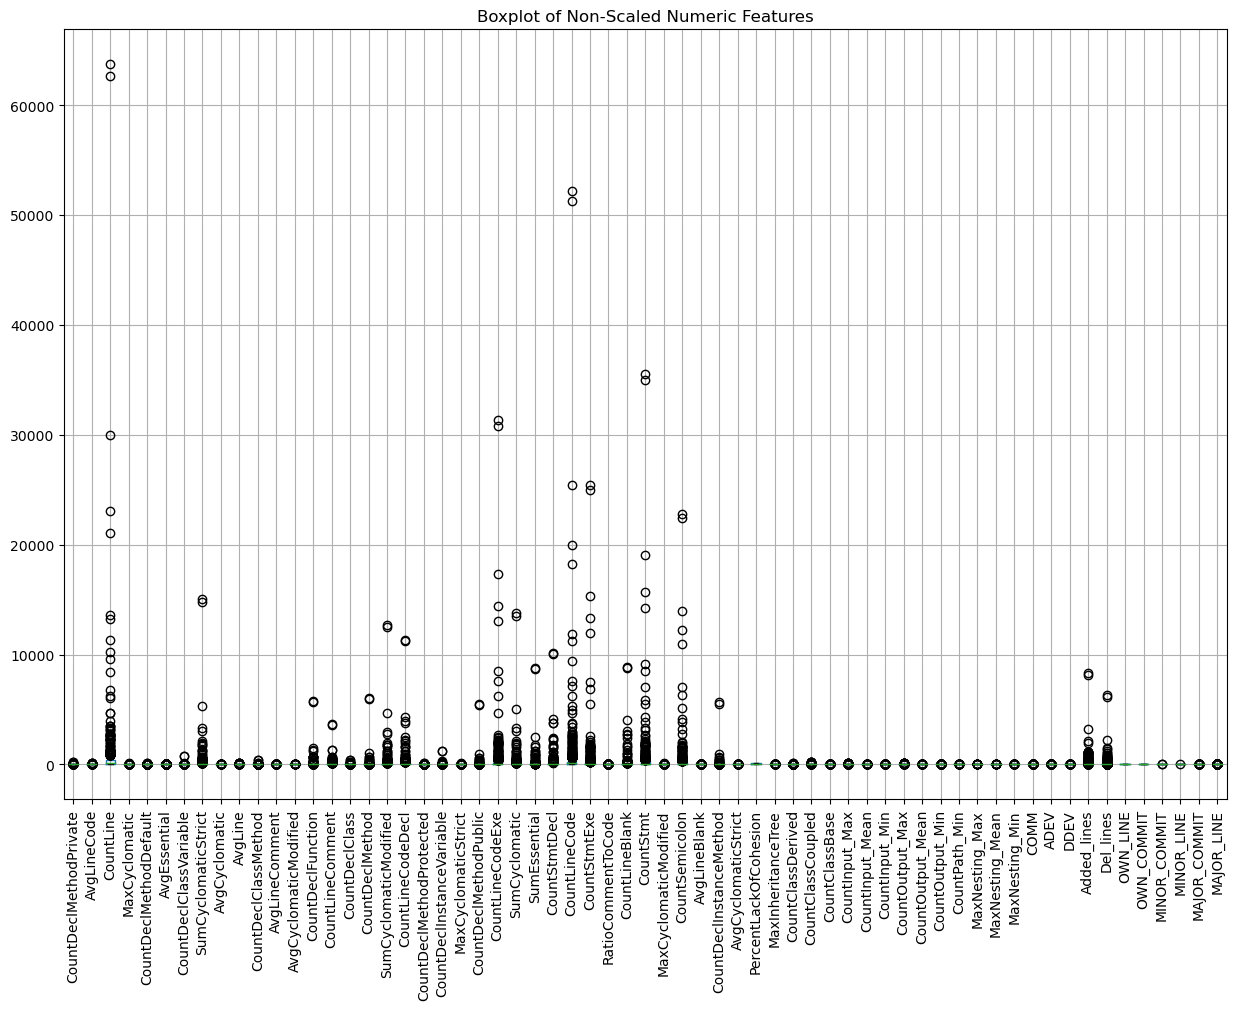

In [8]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,1132.000000,1132.000000,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,...,1132.000000,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1.132000e+03,1132.000000,1132.000000,1.132000e+03
mean,0.000000,0.000000,-2.510752e-17,-2.510752e-17,6.276879e-18,-6.276879e-17,-6.276879e-18,-1.255376e-17,-1.255376e-17,1.255376e-17,...,0.000000,-5.021503e-17,1.255376e-17,2.510752e-17,7.532255e-17,-1.255376e-17,-9.415319e-18,0.000000,0.000000,-5.021503e-17
std,1.000442,1.000442,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,...,1.000442,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442e+00,1.000442,1.000442,1.000442e+00
min,-0.182953,-0.983194,-1.871213e-01,-7.979258e-01,-1.126455e-01,-1.041817e+00,-1.068334e-01,-1.445850e-01,-1.212560e+00,-1.025787e+00,...,-0.402241,-5.573607e-01,-1.596702e-01,-1.247597e-01,-2.330562e+00,-7.352977e-01,-4.207032e-02,-1.627585,-0.560974,-5.521338e-01
25%,-0.182953,-0.618643,-1.628006e-01,-5.828402e-01,-1.126455e-01,-1.449828e-01,-1.068334e-01,-1.357089e-01,-6.753318e-01,-6.513542e-01,...,-0.402241,-5.573607e-01,-1.596702e-01,-1.247597e-01,-8.443603e-01,-7.352977e-01,-4.207032e-02,-0.881663,-0.560974,-5.521338e-01
50%,-0.182953,-0.254091,-1.401013e-01,-3.677546e-01,-1.126455e-01,-1.449828e-01,-1.068334e-01,-1.194359e-01,-1.381037e-01,-2.769215e-01,...,-0.402241,-5.573607e-01,-1.596702e-01,-1.247597e-01,1.001871e-01,-7.352977e-01,-4.207032e-02,-0.135742,-0.560974,-5.521338e-01
75%,-0.021154,0.292736,-6.389641e-02,2.775022e-01,-1.126455e-01,-1.449828e-01,-4.392813e-02,-5.841241e-02,3.991244e-01,3.221709e-01,...,0.075552,5.138317e-01,-1.283549e-01,-1.213474e-01,1.007774e+00,5.703137e-01,-4.207032e-02,0.610179,0.524535,1.813578e-02
max,20.608279,8.312871,2.046991e+01,1.393544e+01,2.320434e+01,1.779169e+01,2.354556e+01,2.209756e+01,1.168091e+01,8.634578e+00,...,12.975955,6.940986e+00,2.113728e+01,2.128738e+01,1.201639e+00,1.875925e+00,2.376973e+01,3.593865,7.037591,6.861371e+00


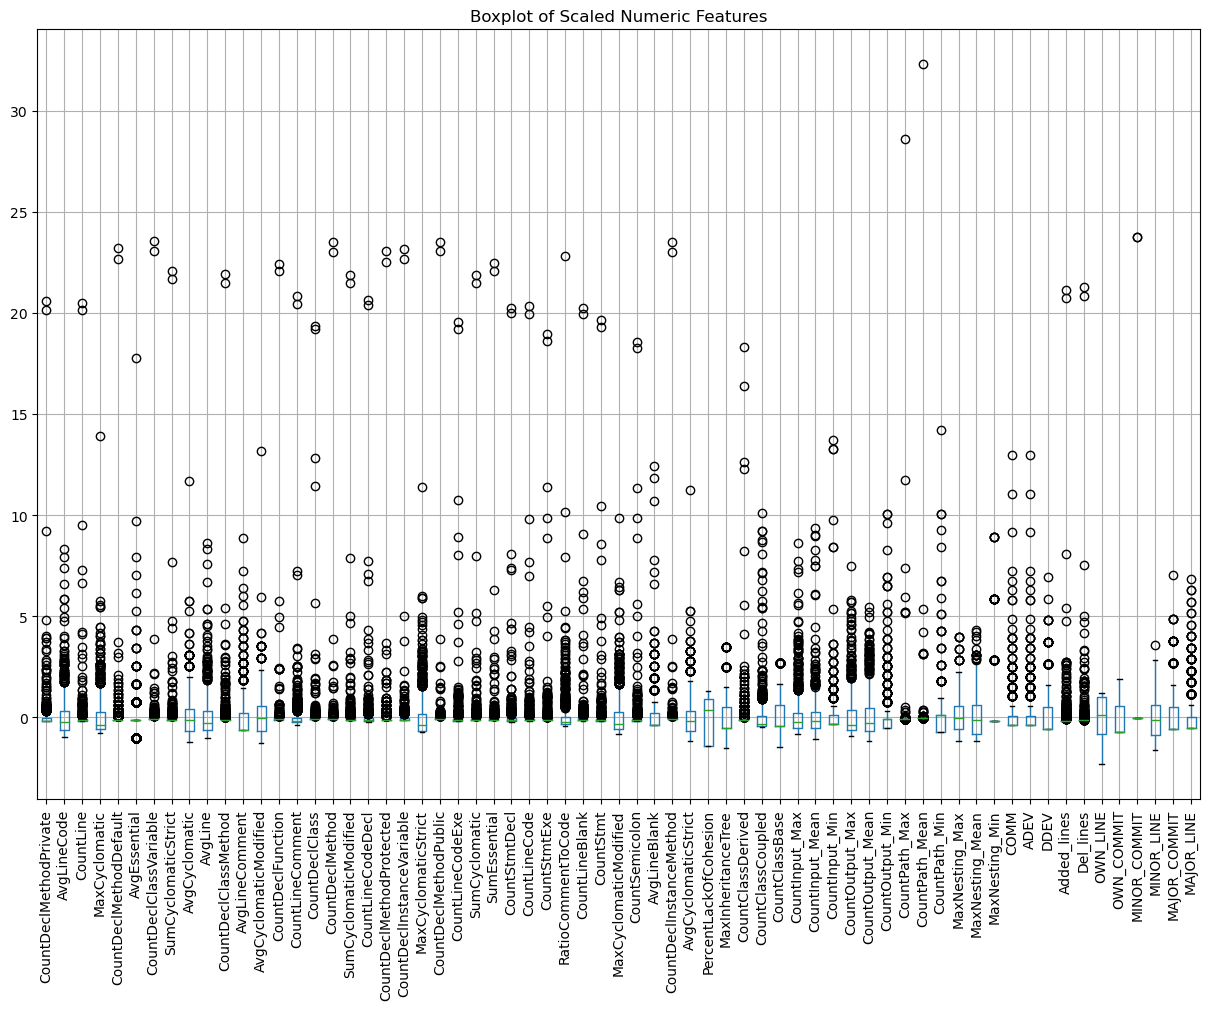

In [10]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()